In [4]:
#pip install tensorflow

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#TensorFLow
import tensorflow as tf
from tensorflow import keras

from sklearn.decomposition import PCA

np.random.seed(23) #kallisti

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
sns.set()

print(tf.__version__)

2.15.0


## The Fashion-MNIST dataset

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747
https://github.com/zalandoresearch/fashion-mnist

##### The below workflow is inspired by UC Berkeley's Data100 lecture 

In [35]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [36]:
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

The class names are not included with the dataset.

In [37]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_dict = {i:class_name for i,class_name in enumerate(class_names)}
class_dict

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

### Random Sample to Truncate:
10,000 train
1,000 test

In [38]:
rng = np.random.default_rng(42)
n_train, n_test = 10000, 1000
train_samples = rng.choice(np.arange(len(train_images)), size=n_train, replace=False)
test_samples = rng.choice(np.arange(len(test_images)), size=n_test, replace=False)

train_images, train_labels = train_images[train_samples,:,:], train_labels[train_samples]
test_images, test_labels = test_images[test_samples,:,:], test_labels[test_samples]

train_images.shape, test_images.shape

((10000, 28, 28), (1000, 28, 28))

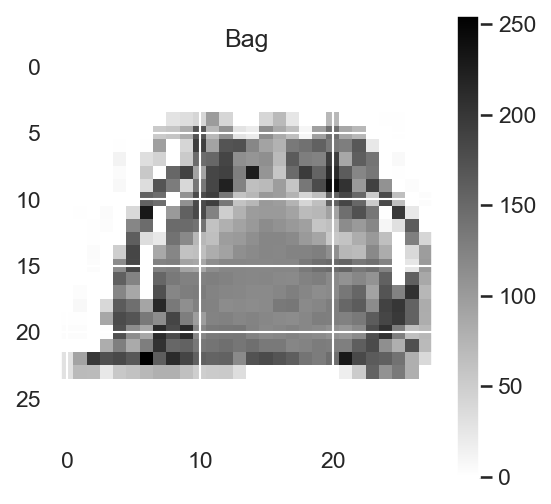

In [39]:
def show_train_image(index):
    plt.figure()
    # cmap=plt.cm.binary allows us to show the picture in grayscale
    plt.imshow(train_images[index], cmap=plt.cm.binary)
    plt.title(class_names[train_labels[index]])
    plt.colorbar() # adds a bar to the side with values
    plt.show()
show_train_image(15)

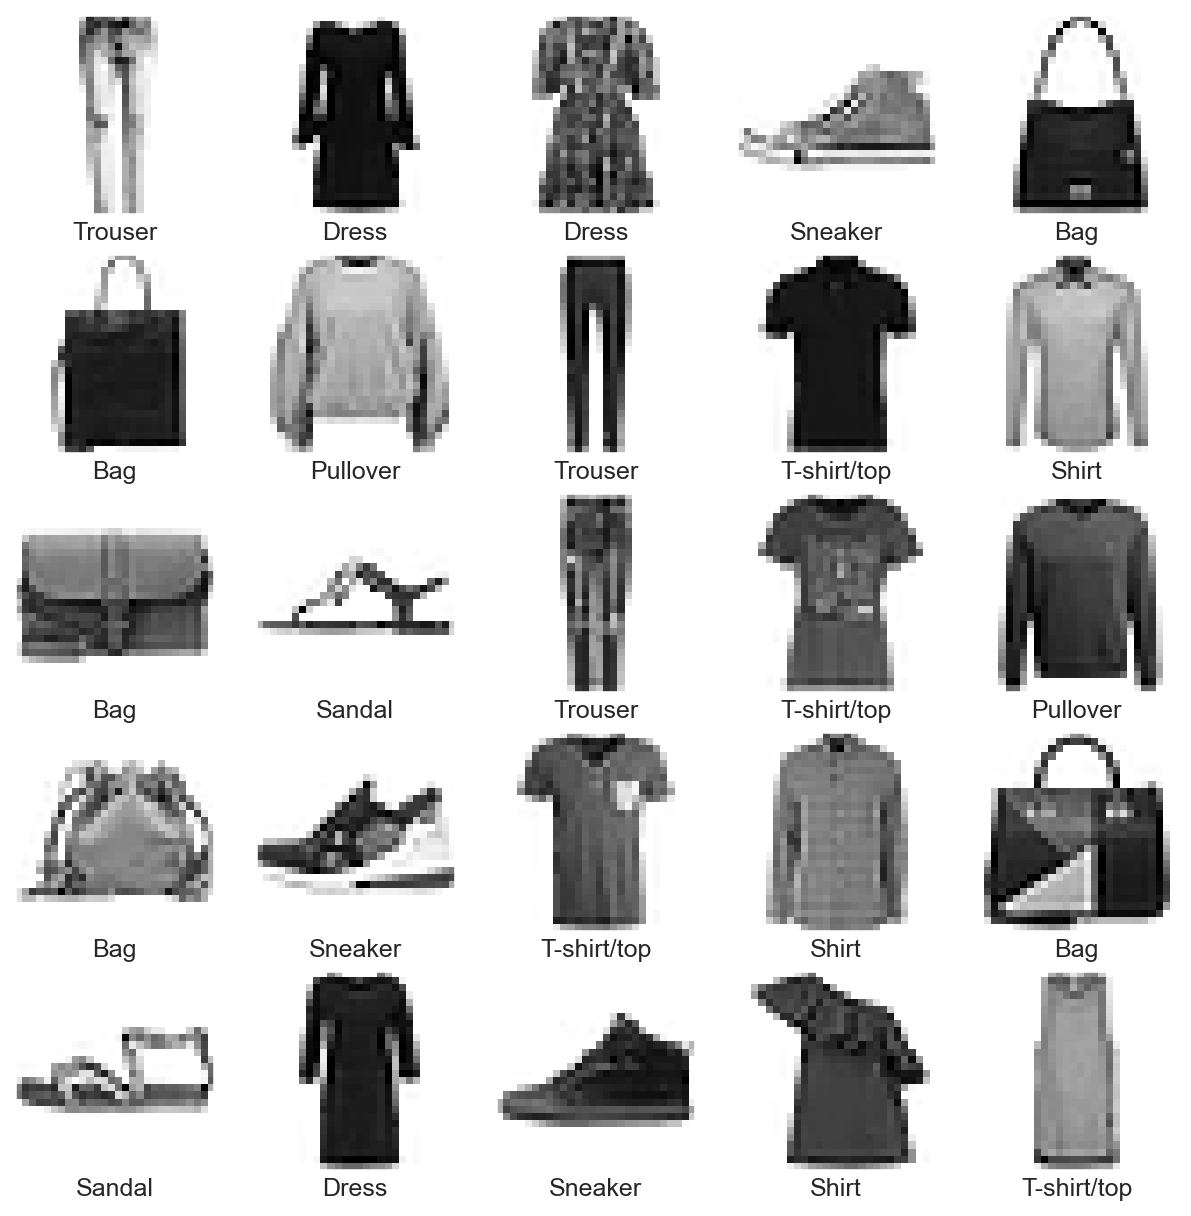

In [40]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

### Training a Logistic Regression Classifier 
Distinguishing between two specific classes of clothes with binary classification.

#### Preprocessing:

The pixel values fall in range 0 to 255. With image data, its better to normalize to a range of 0 to 1. 

Train Min:0.0 Max:1.0
Test Min:0.0 Max:1.0


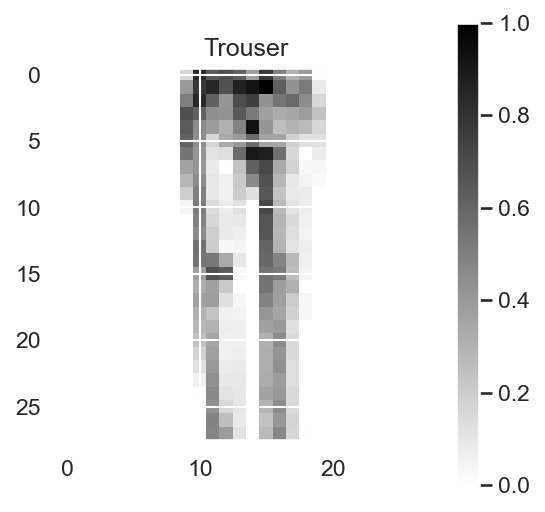

In [41]:
train_images = train_images/255
test_images = test_images/255

print(f'Train Min:{train_images.min()} Max:{train_images.max()}')

print(f'Test Min:{test_images.min()} Max:{test_images.max()}')

show_train_image(0)

### Reshape features into 1-D

logistic regression relies on features being 1-D (a vector). 
- Our data is comprised of grayscale iamges with a resolution og 28x28
- We can think of this as the images existing in a 28*28 = 784 dim space
- we need to reshape every image to be represented by a vector of length 784

In [42]:
# reshaping images
train_images_vectors = np.reshape(train_images, (len(train_images), -1))
test_images_vectors = np.reshape(test_images, (len(test_images), -1))
train_images_vectors.shape, test_images_vectors.shape

((10000, 784), (1000, 784))

In [43]:
# add class/label to DataFrame
train_df = pd.DataFrame(train_images_vectors)
train_df['label'] = train_labels
train_df['class'] = train_df['label'].map(class_dict)

# reorder columns
PIXEL_COLS = train_df.columns.tolist()[:-2]
LABEL_COLS = ['label', 'class']

cols_reorder = LABEL_COLS + PIXEL_COLS
train_df = train_df[cols_reorder]
train_df

,label,class,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,1,Trouser,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,3,Dress,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.243137,0.160784,0.000000,0.000000,0.007843,0.000000,0.000000,0.0,0.0,0.0
2,3,Dress,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.596078,0.584314,0.203922,0.196078,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,7,Sneaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,8,Bag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.576471,0.568627,0.509804,0.470588,0.556863,0.168627,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,Pullover,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.600000,0.223529,0.047059,0.0,0.0,0.0
9996,0,T-shirt/top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.317647,0.137255,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9997,0,T-shirt/top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007843,...,0.494118,0.619608,0.003922,0.000000,0.011765,0.000000,0.000000,0.0,0.0,0.0
9998,6,Shirt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [47]:
#same for test set
test_df = pd.DataFrame(test_images_vectors)
test_df['label'] = test_labels
test_df['class'] = test_df['label'].map(class_dict)

cols_reorder = LABEL_COLS + PIXEL_COLS
test_df = test_df[cols_reorder]

### Principal Component Analysis
We cannot with our won eyes visibly see how the features (each pixel) change with different classes so we can do this difference with higher-order shapes using PCA

In [48]:
n_comps = 50
PCA_COLS = [f"pc{i+1}" for i in range(n_comps)]
pca = PCA(n_components=n_comps)
pca.fit(train_df[PIXEL_COLS])
principal_components = pca.transform(train_df[PIXEL_COLS])

In [49]:
# The first 50 components
principal_components.shape

(10000, 50)

In [50]:
# the first 50 components account for a lot of the total variance
np.sum(pca.explained_variance_ratio_)

0.8631295806642577

In [51]:
# PC1, PC2 component scores
np.sum(pca.explained_variance_ratio_[:2])

0.46900515837502404

Text(0.5, 0, 'Component Number')

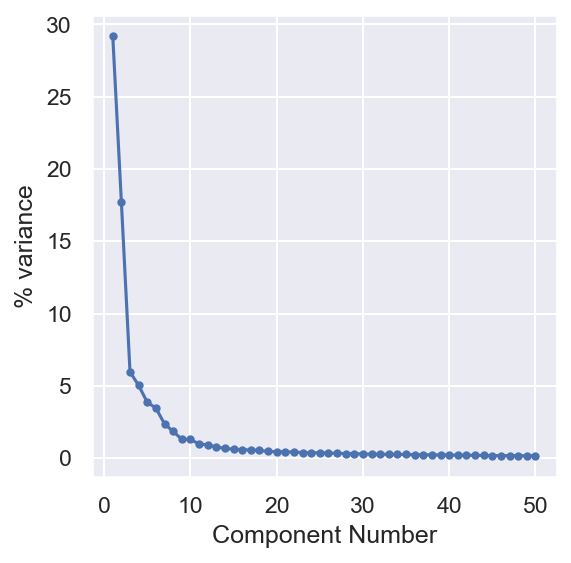

In [52]:
plt.plot(np.arange(n_comps)+1,
         100*pca.explained_variance_ratio_,
         marker='.');
plt.ylabel("% variance")
plt.xlabel("Component Number")

In [53]:
def build_comps_df(components, label_df, colnames):
    df = pd.DataFrame(data=components,
                      columns=colnames)
    df["class"] = label_df["class"]
    df["label" ] = label_df["label"]
    return df

Text(0.5, 1.0, 'PCA visualization (PC2 vs. PC1)')

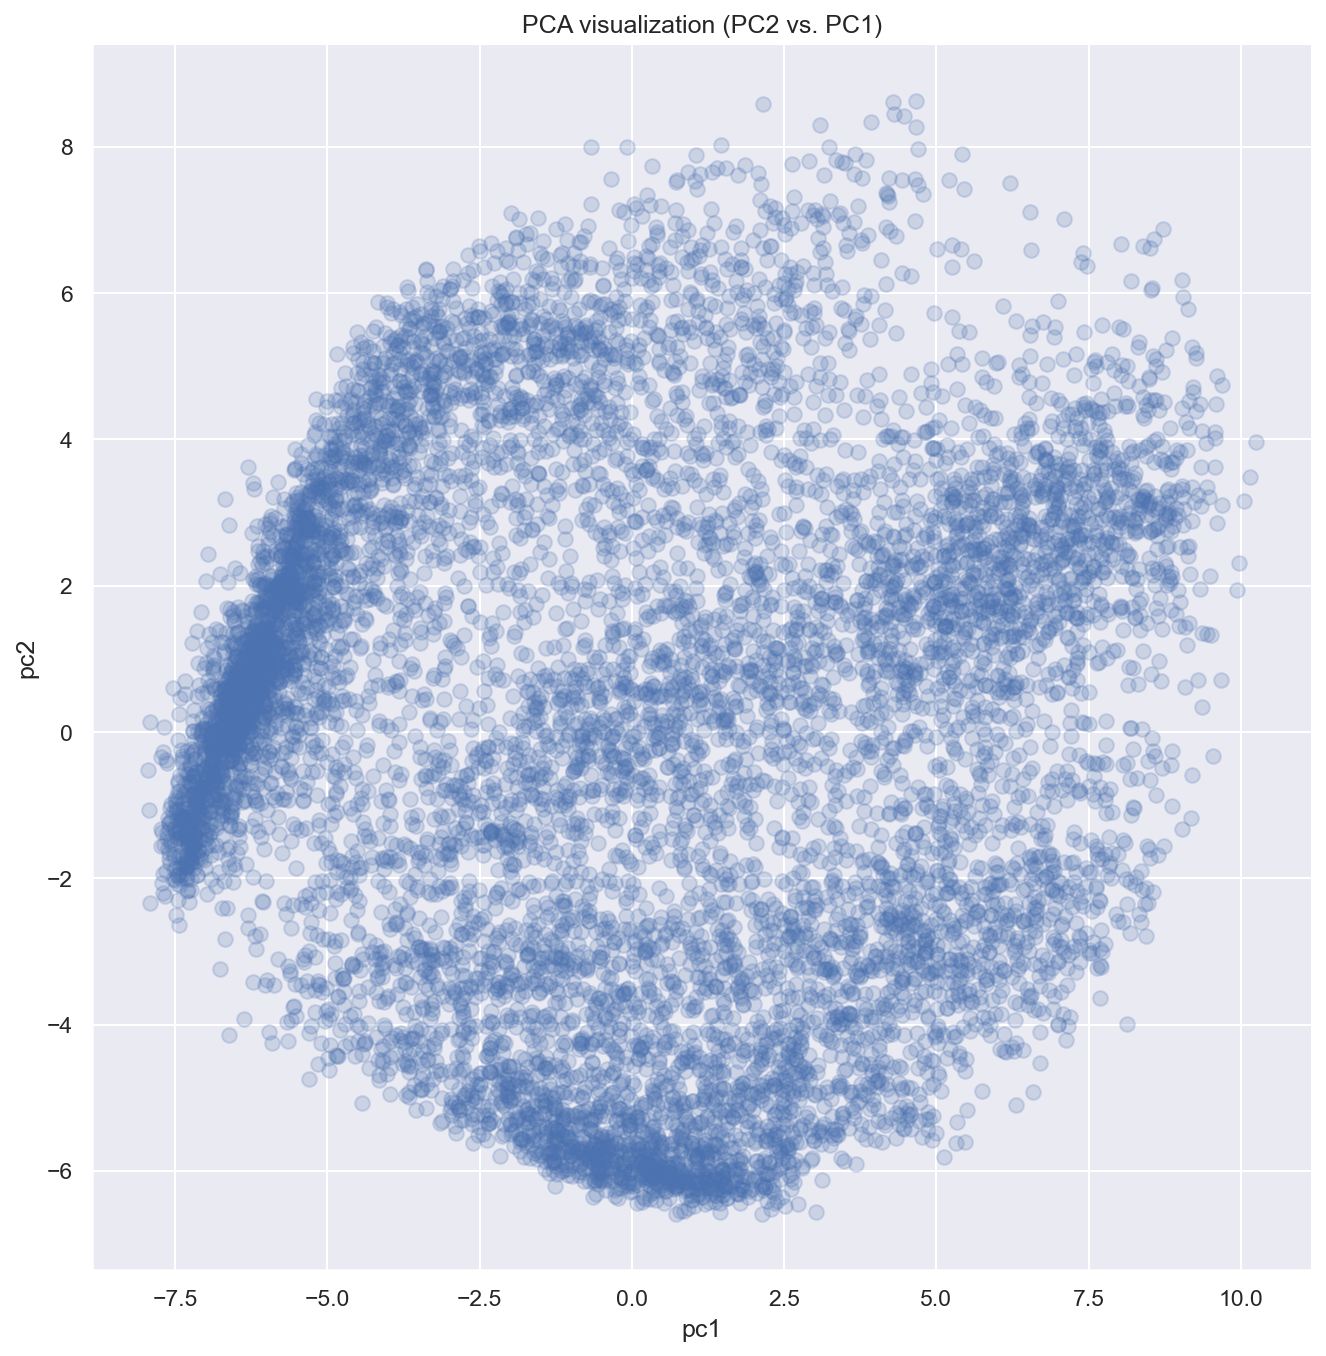

In [54]:
pca_df = build_comps_df(principal_components, train_df, PCA_COLS)
# plot pca, uncomment for classes.
sns.lmplot(x='pc1',
           y='pc2',
           data=pca_df, 
           fit_reg=False, 
           # hue='class',
           height=9,
           scatter_kws={"s":50,"alpha":0.2})
plt.title("PCA visualization (PC2 vs. PC1)")

### Logistic Regression 

In [93]:
#taking a subset of the data for two given labels
def get_data_subset_binary(df, class0, class1, featnames, shuffle=True, shuffle_seed=42):
    df_filtered = df[(df["class"] == class0) | (df["class"] == class1)].copy()
    df_filtered["binary_label"] = 0
    df_filtered.loc[df["class"] == class1, "binary_label"] = 1
    data = df_filtered[featnames].values
    labels = df_filtered["binary_label"].values
    return data, labels

### Classifier 1: Dress v. Bag

- **Dress (0)**
- **Bag (1)**

Training the model on the 50 principal components, which reduces multicollinearity between features

In [94]:
data_bottoms, labels_bottoms = get_data_subset_binary(pca_df, "Dress", "Bag", PCA_COLS)
print(len(data_bottoms), "datapoints")

2026 datapoints


In [95]:
from sklearn.linear_model import LogisticRegression

model_bottoms = LogisticRegression(random_state=42, solver="sag")

In [96]:
model_bottoms.fit(data_bottoms, labels_bottoms)

/Users/sarasharifzadeh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(random_state=42, solver='sag')

### Classifier 1: Dress v. Bag

- **Dress (0)**
- **Bag (1)**

#### Performance?

In [97]:
from sklearn.metrics import accuracy_score

preds_bottoms = model_bottoms.predict(data_bottoms)
accuracy_score(labels_bottoms, preds_bottoms)

0.991609081934847

#### Classifier 1: is it linearly separable?

/Users/sarasharifzadeh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarasharifzadeh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'PCA visualization (PC2 vs. PC1)')

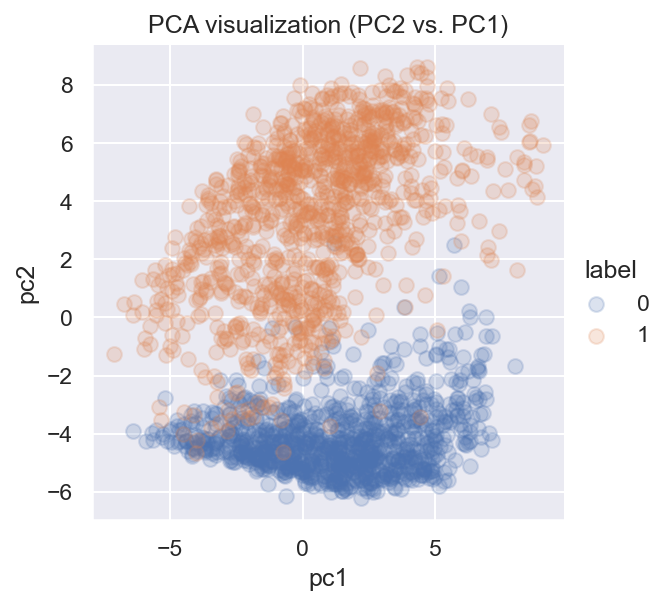

In [98]:
# plot pca, uncomment for classes.
visualize_df = pd.DataFrame(
    {"pc1": data_bottoms[:,0],
     "pc2": data_bottoms[:,1],
     "label": labels_bottoms
    })
sns.lmplot(x="pc1",
           y="pc2",
           fit_reg=False,
           data=visualize_df,
           hue="label",
           height=4,
           scatter_kws={"s":50,"alpha":0.2})
plt.title("PCA visualization (PC2 vs. PC1)")

In [99]:
### CLassifier 1: Test Performance

# 1. rotate test data to "principal components" space
principal_components = pca.transform(test_df[PIXEL_COLS])
pca_test_df = build_comps_df(principal_components, test_df, PCA_COLS)

# 2. subset with target binary labels 
data_bottoms_test, labels_bottoms_test = \
    get_data_subset_binary(pca_test_df, "Dress", "Bag", PCA_COLS)
print(len(data_bottoms_test), "datapoints")

188 datapoints


In [100]:
# 3. predict using logistic regression
preds_bottoms_test = model_bottoms.predict(data_bottoms_test)
accuracy_score(labels_bottoms_test, preds_bottoms_test)

0.9893617021276596

### Classifier 2: Dress v. TShirt/top

- **Dress (0)**
- **T-Shirt/top (1)**

In [101]:
'T-shirt/top'

data_tops, labels_tops = get_data_subset_binary(pca_df, "Dress", "T-shirt/top", PCA_COLS)
print(len(data_tops), "datapoints")

1983 datapoints


In [102]:
from sklearn.linear_model import LogisticRegression

model_tops = LogisticRegression(verbose=False, random_state=42, solver="sag")
model_tops.fit(data_tops, labels_tops)

/Users/sarasharifzadeh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(random_state=42, solver='sag', verbose=False)

In [103]:
preds_tops = model_tops.predict(data_tops)
accuracy_score(labels_tops, preds_tops)

0.940494200706001

In [104]:
# 1. (done earlier) rotate test data to "principal components" space
# 2. subset with target binary labels 
data_tops_test, labels_tops_test = \
    get_data_subset_binary(pca_test_df, "Dress", "T-shirt/top", PCA_COLS)
print(len(data_tops_test), "datapoints")

198 datapoints


In [105]:
# 3. predict using logistic regression
preds_tops_test = model_tops.predict(data_tops_test)
accuracy_score(labels_tops_test, preds_tops_test)

0.9343434343434344

/Users/sarasharifzadeh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarasharifzadeh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'PCA visualization (PC2 vs. PC1) (test)')

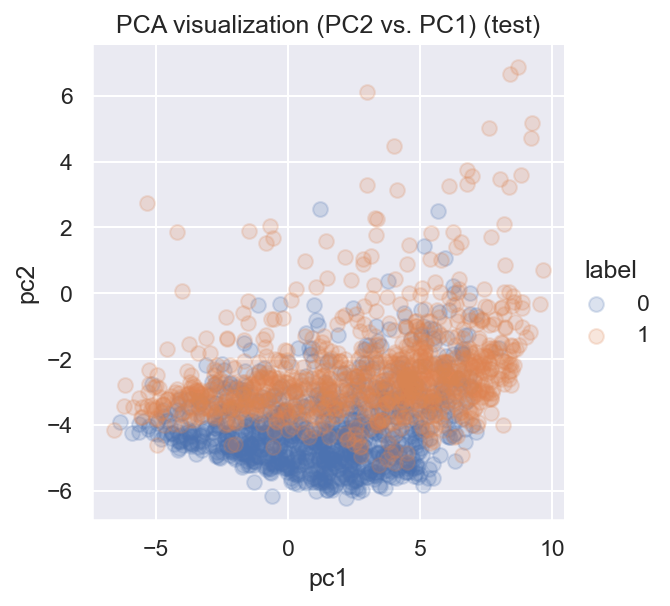

In [106]:
# plot pca, uncomment for classes.
visualize_df = pd.DataFrame(
    {"pc1": data_tops[:,0],
     "pc2": data_tops[:,1],
     "label": labels_tops
    })
sns.lmplot(x="pc1",
           y="pc2",
           fit_reg=False,
           data=visualize_df,
           hue="label",
           height=4,
           scatter_kws={"s":50,"alpha":0.2})
plt.title("PCA visualization (PC2 vs. PC1) (test)")

In [118]:
#pip install umap-learn

### UMAP
Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation.

In [112]:
import umap
from sklearn.datasets import load_digits

digits = load_digits()

embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(digits.data)

In [113]:
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf

In [117]:
palette = [
    "#9e0142",
    "#d8434e",
    "#f67a49",
    "#fdbf6f",
    "#feeda1",
    "#f1f9a9",
    "#bfe5a0",
    "#74c7a5",
    "#378ebb",
    "#5e4fa2",
]
color_key = {str(d): c for d, c in enumerate(pal)}
color_key

{'0': '#9e0142',
 '1': '#d8434e',
 '2': '#f67a49',
 '3': '#fdbf6f',
 '4': '#feeda1',
 '5': '#f1f9a9',
 '6': '#bfe5a0',
 '7': '#74c7a5',
 '8': '#378ebb',
 '9': '#5e4fa2'}

In [134]:
#different loading for U-MAP
import os
import requests
if not os.path.isfile("fashion-mnist.csv"):
    csv_data = requests.get("https://www.openml.org/data/get_csv/18238735/phpnBqZGZ")
    with open("fashion-mnist.csv", "w") as f:
        f.write(csv_data.text)
source_df = pd.read_csv("fashion-mnist.csv")

data = source_df.iloc[:, :784].values.astype(np.float32)
target = source_df["class"].values

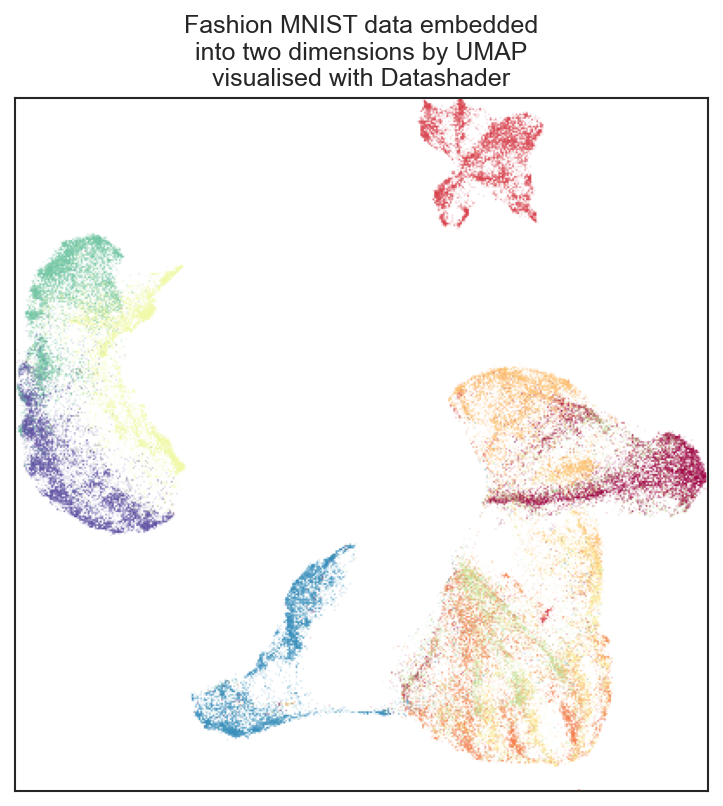

In [137]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

df = pd.DataFrame(embedding, columns=("x", "y"))
df["class"] = pd.Series([str(x) for x in target], dtype="category")

cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(df, "x", "y", ds.count_cat("class"))
img = tf.shade(agg, color_key=color_key, how="eq_hist")

utils.export_image(img, filename="fashion-mnist", background="white")

sns.set(context="paper", style="white")

image = plt.imread("fashion-mnist.png")
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(image)
plt.setp(ax, xticks=[], yticks=[])
plt.title(
    "Fashion MNIST data embedded\n"
    "into two dimensions by UMAP\n"
    "visualised with Datashader",
    fontsize=12,
)

plt.show()